In [1]:
!pip install comet_ml
import comet_ml
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import numpy as np
import pandas as pd
import os
import time
import IPython.display as display


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.1/979.1 kB 45.9 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.2.0
    Uninstalling python-box-7.2.0:
      Successfully uninstalled python-box-7.2.0


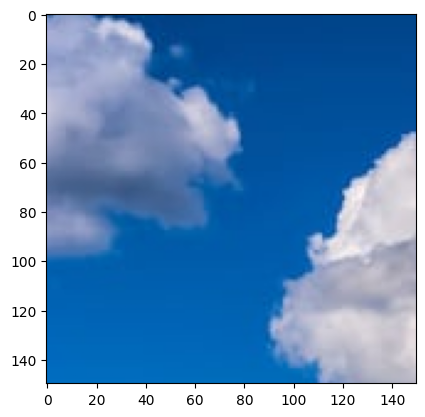

In [2]:
#get into related to single image
#image = imread("D_img1.png")
#plt.imshow(image)
#image.size, image.shape, image.ndim

BUFFERSIZE = 700
#buffer needs to be greater than or equal to data set
BATCH_SIZE = 175
IMG_SIZE = 150
SAMPLES = 350

#get all images
train_images = np.zeros(shape=(SAMPLES, IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
for i in range(0, 349):
    train_images[i] = imread("D_img" + str((i+1)) + ".png")

plt.imshow(train_images[0])
#shuffles the dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFERSIZE).batch(BATCH_SIZE)

In [3]:
#(5 * 2) * 3 * 5 for layers to get 150
def make_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(10*10*252, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((10, 10, 252)),
        #assert model.output_shape == (None, 10, 10, 252) #can't do this because not here

        tf.keras.layers.Conv2DTranspose(252, (10, 10), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(63, (10, 10), strides=(3, 3), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        #assert model.output_shape == (None, 20, 20, 63)

        tf.keras.layers.Conv2DTranspose(31, (10, 10), strides=(5, 5), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='sigmoid')
        #assert model.output_shape == (None, 150, 150, 3)
    ])
    assert model.output_shape == (None, 150, 150, 3)
    return model

tf.Tensor(
[[[0.49996015 0.5000153  0.49997032]
  [0.50008017 0.49987745 0.49987054]
  [0.4999887  0.5000817  0.50024384]
  ...
  [0.49993244 0.49981934 0.49990964]
  [0.49996898 0.4999896  0.50032324]
  [0.50000197 0.49998412 0.49994376]]

 [[0.49972862 0.49996033 0.5001584 ]
  [0.50000495 0.50011307 0.5000128 ]
  [0.49975333 0.4999651  0.4999745 ]
  ...
  [0.49995112 0.49969086 0.4999629 ]
  [0.49990615 0.5001397  0.50022084]
  [0.49980643 0.499879   0.49998495]]

 [[0.49999693 0.499655   0.5001069 ]
  [0.5000133  0.49972945 0.49990815]
  [0.49977928 0.49965057 0.50047904]
  ...
  [0.49964717 0.5003409  0.50011027]
  [0.49981508 0.50018525 0.5002263 ]
  [0.5000754  0.500053   0.50013125]]

 ...

 [[0.49960172 0.4997255  0.50021505]
  [0.4999943  0.5001604  0.50001436]
  [0.50016236 0.5000984  0.4999543 ]
  ...
  [0.5001882  0.49987674 0.50010604]
  [0.5001683  0.50001127 0.49987996]
  [0.49991214 0.49992815 0.5002256 ]]

 [[0.49991372 0.50010186 0.4998317 ]
  [0.5002792  0.49977243 0

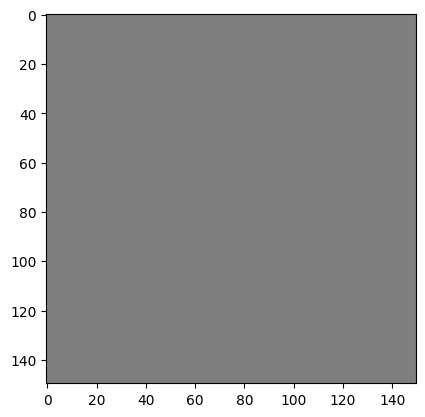

In [4]:
generator = make_generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
#generated_image.shape
#white_image = np.zeros(shape=(150, 150, 3))
#white_image = np.full(shape=(150, 150, 3), fill_value=127)
print(generated_image[0, :, :, :])
plt.imshow(generated_image[0])

In [5]:
def make_discriminator():
  model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, (10, 10), strides=(2, 2), padding='same', input_shape=[150, 150, 3]),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same'),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(128, (10, 10), strides=(2, 2), padding='same'),
      tf.keras.layers.LeakyReLU(),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

  return model

In [6]:
discriminator = make_discriminator()
desicion = discriminator(generated_image)
print(desicion)
discriminator.summary()

tf.Tensor([[0.5148478]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 64)        19264     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 75, 75, 64)        0         
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        102464    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 75, 75, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 75, 75, 64)        0         
                                                                 


In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  #one like function for vector of ones of same length
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  #zero like function for vector of ones of same length
  total = real_loss + fake_loss
  return total

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)
  #wants to fool the discriminator

gen_optimizer = tf.keras.optimizers.Adam(1e-3)
dis_optimizer = tf.keras.optimizers.Adam(1e-3)

In [8]:
#saving code
checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=dis_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
#will save the model params as training goes on

In [9]:
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 7
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [10]:
#training of the variables is just applying gradient descent using loss functions
#after running both models
#tf funct because causes funct to be compiled (run faster)
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim]) #gets the noise for generator
  with tf.GradientTape() as gen_t, tf.GradientTape() as dis_t:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)
    dis_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_t.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = dis_t.gradient(dis_loss, discriminator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  dis_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [11]:
#to train model just take the steps for each epoch
def trainmodel(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    #display each image after 100 steps
    if (epoch % 2 == 0):
      display.clear_output(wait=True)
      generate_and_save_images(generator, epoch + 1, seed)
    # Save the model every 200 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    if(epoch + 1) % 2 == 0:
      print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  #generate a set of images after epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)


In [12]:
#takes in the epoch for display which epoch is being shown
#test input and model used to generate set of images
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False) #train fales bc duh

  fig = plt.figure(figsize=(5, 5))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

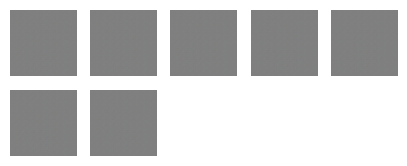

In [ ]:
#exp = comet_ml.Experiment(
 #   api_key='xUELgBjS6eWY8xy6DBOOJS6Dj',
 #   project_name='GAN'
#)
trainmodel(train_dataset, EPOCHS)
#exp.end()

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir)) #gets the lastest checkpoint before training again